In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from pymongo import MongoClient
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil

In [ ]:
# source_folder = '../RSSCN7'
# dest_folder = '../query_images'

# if not os.path.exists(dest_folder):
#     os.makedirs(dest_folder)

# for category in os.listdir(source_folder):
#     category_path = os.path.join(source_folder, category)
#     if not os.path.isdir(category_path):
#         continue
    
#     images = [img for img in os.listdir(category_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
#     random_images = random.sample(images, min(num_images, len(images)))
    
#     for img_name in random_images:
#         src_path = os.path.join(category_path, img_name)
#         dest_path = os.path.join(dest_folder, img_name)
#         shutil.move(src_path, dest_path)

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client['RSSCN7']
collection = db['descriptors']

In [3]:
def get_dominant_colors(image, k=16):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_.tolist()

In [4]:
def get_gabor_texture(image):
    def build_gabor_filters():
        filters = []
        for theta in range(4):
            theta = theta * 45
            for sigma in (3, 5):
                for frequency in (0.01, 0.05):
                    kernel = cv2.getGaborKernel((5, 5), sigma, theta, frequency, 0.5, 0, ktype=cv2.CV_32F)
                    filters.append(kernel)
        return filters
    filters = build_gabor_filters()
    responses = []
    for kernel in filters:
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        responses.append(filtered.mean())
    return responses

In [5]:
def get_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten().tolist()

In [6]:
def get_hu_moments(image):
    epsilon = 1e-10
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return [0.0] * 7
    contour = max(contours, key=cv2.contourArea)
    moments = cv2.moments(contour)
    hu = cv2.HuMoments(moments)
    hu = [-np.log10(np.abs(h) + epsilon).item() for h in hu]
    return hu

In [7]:
def get_edge_histogram(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten().tolist()

In [ ]:
def get_fourier_descriptors(image, n=20):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return [0.0] * (2 * n)
    contour = max(contours, key=cv2.contourArea)
    contour = contour.reshape(-1, 2).T
    fourier = np.fft.fft(contour, n=n, axis=1)
    magnitudes = np.abs(fourier)
    return magnitudes.flatten().tolist()

In [9]:
def process_database_images(root_folder):
    for category in os.listdir(root_folder):
        category_path = os.path.join(root_folder, category)
        if not os.path.isdir(category_path):
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            # Resize image if necessary
            img = cv2.resize(img, (200, 200))
            # Extract descriptors
            dominant_colors = get_dominant_colors(img)
            texture = get_gabor_texture(img)
            color_hist = get_color_histogram(img)
            hu_moments = get_hu_moments(img)
            edge_hist = get_edge_histogram(img)
            fourier_desc = get_fourier_descriptors(img)
            # Store in MongoDB
            doc = {
                'image_path': img_path,
                'category': category,
                'dominant_colors': dominant_colors,
                'texture': texture,
                'color_histogram': color_hist,
                'hu_moments': hu_moments,
                'edge_histogram': edge_hist,
                'fourier_descriptors': fourier_desc
            }
            collection.insert_one(doc)

In [10]:
def process_query_image(query_path):
    img = cv2.imread(query_path)
    if img is None:
        return None
    img = cv2.resize(img, (200, 200))
    # Extract descriptors
    dominant_colors = get_dominant_colors(img)
    texture = get_gabor_texture(img)
    color_hist = get_color_histogram(img)
    hu_moments = get_hu_moments(img)
    edge_hist = get_edge_histogram(img)
    fourier_desc = get_fourier_descriptors(img)
    return {
        'dominant_colors': dominant_colors,
        'texture': texture,
        'color_histogram': color_hist,
        'hu_moments': hu_moments,
        'edge_histogram': edge_hist,
        'fourier_descriptors': fourier_desc
    }

In [32]:
# process_database_images('../RSSCN7')

In [35]:
def compute_similarity(query_desc, db_desc):
    # Define weights for each descriptor
    weights = {
        'dominant_colors': 1.0,
        'texture': 1.0,
        'color_histogram': 1.0,
        'hu_moments': 1.0,
        'edge_histogram': 1.0,
        'fourier_descriptors': 1.0
    }
    total_weight = sum(weights.values())
    similarities = []
    c_hist1 = np.array(query_desc['color_histogram'], dtype=np.float32)
    c_hist1 = c_hist1.astype(np.float32)
    e_hist1 = np.array(query_desc['edge_histogram'], dtype=np.float32)
    e_hist1 = e_hist1.astype(np.float32)
    for doc in db_desc:
        similarity = 0
        # Dominant Colors - Euclidean distance
        dist = np.linalg.norm(np.array(query_desc['dominant_colors']) - np.array(doc['dominant_colors']))
        similarity += weights['dominant_colors'] * (1 / (1 + dist))
        # Texture - Euclidean distance
        dist = np.linalg.norm(np.array(query_desc['texture']) - np.array(doc['texture']))
        similarity += weights['texture'] * (1 / (1 + dist))
        # Color Histogram - Chi-square distance
        c_hist2 = np.array(doc['color_histogram'], dtype=np.float32)
        c_hist2 = c_hist2.astype(np.float32)
        chi_square = cv2.compareHist(c_hist1, c_hist2, cv2.HISTCMP_CHISQR)
        similarity += weights['color_histogram'] * (1 / (1 + chi_square))
        # Hu Moments - Euclidean distance
        dist = np.linalg.norm(np.array(query_desc['hu_moments']) - np.array(doc['hu_moments']))
        similarity += weights['hu_moments'] * (1 / (1 + dist))
        # Edge Histogram - Chi-square distance
        e_hist2 = np.array(doc['edge_histogram'], dtype=np.float32)
        e_hist2 = e_hist2.astype(np.float32)
        chi_square = cv2.compareHist(e_hist1, e_hist2, cv2.HISTCMP_CHISQR)
        similarity += weights['edge_histogram'] * (1 / (1 + chi_square))
        # Fourier Descriptors - Euclidean distance
        dist = np.linalg.norm(np.array(query_desc['fourier_descriptors']) - np.array(doc['fourier_descriptors']))
        similarity += weights['fourier_descriptors'] * (1 / (1 + dist))
        # Normalize similarity
        similarity /= total_weight
        similarities.append((doc, similarity))
    # Sort by similarity
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities

In [36]:
def get_top_images(similarities, x=5):
    top = similarities[:x]
    return [ (doc['image_path'], sim) for doc, sim in top ]

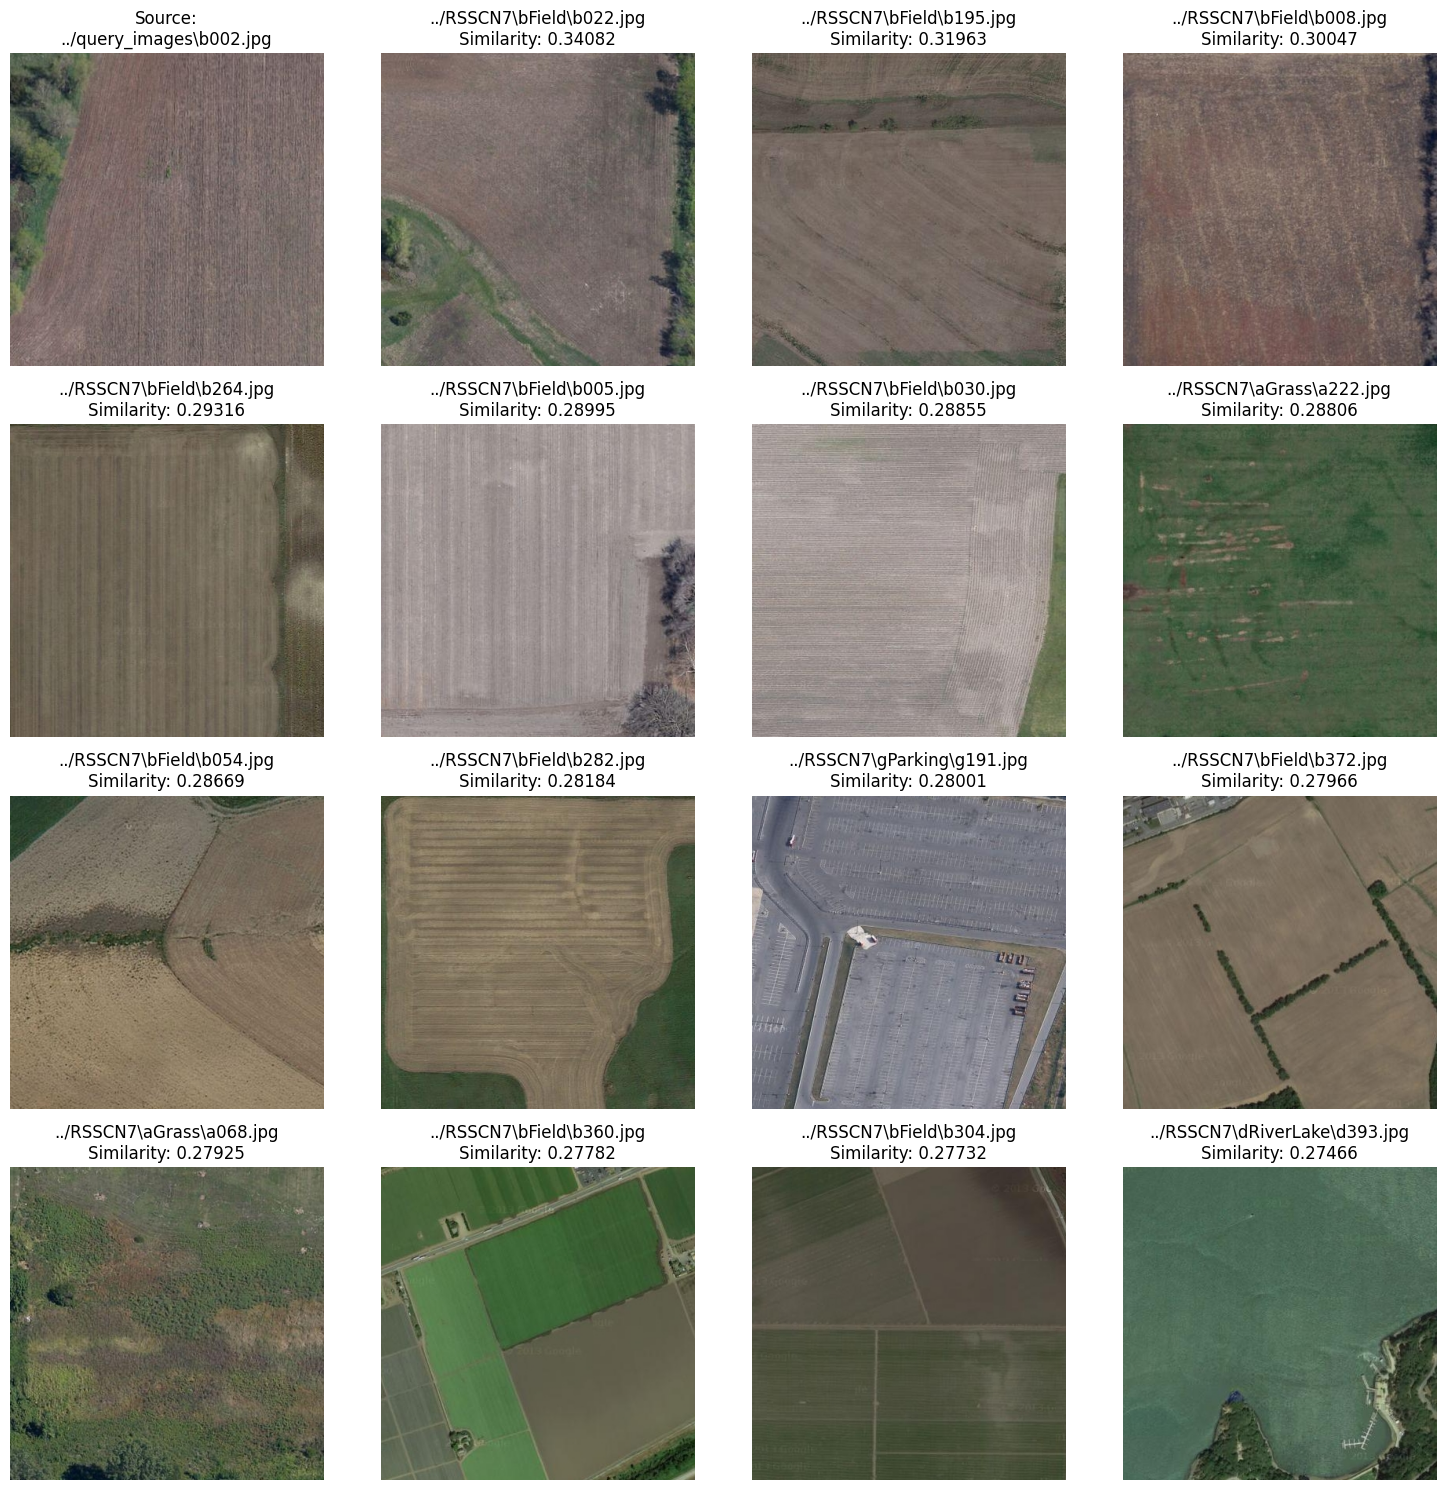

In [39]:
query_imgs = os.listdir('../query_images')
rand_img = random.choice(query_imgs)
query_path = os.path.join('../query_images', rand_img)
query_desc = process_query_image(query_path)
if query_desc is None:
    print("Invalid query image.")
else:
    db_desc = list(collection.find())
    similarities = compute_similarity(query_desc, db_desc)
    n = 15
    top_images = get_top_images(similarities, n)
    rows = 4
    cols = (n + 1) // rows + ((n + 1) % rows > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    img1 = Image.open(query_path)
    axes[0, 0].imshow(img1, cmap='gray')
    axes[0, 0].set_title(f"Source:\n{query_path}")
    axes[0, 0].axis("off")
    for i, (img_path, sim) in enumerate(top_images):
        row = (i + 1) // cols
        col = (i + 1) % cols
        img2 = Image.open(img_path)
        axes[row, col].imshow(img2, cmap='gray')
        axes[row, col].set_title(f"{img_path}\nSimilarity: {sim:.5f}")
        axes[row, col].axis("off")
    plt.tight_layout()
    plt.show()